# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
def C_L0_norm(x):
    '''L0 norm function for each element of a vector'''
    if x != 0:
        return 0.0
    else:
        return 1.0

def C_L1_norm(x):
    '''L1 norm function for each element of a vector'''
    return abs(x)

def C_L0_norm_deriv(x):
    '''Derivative of C_L0_norm'''
    if x != 0:
        return 0.0
    else:
        return np.inf
    
def C_L1_norm(x):
    '''Derivative of C_L1_norm'''
    if x < 0:
        return -1.0
    elif x > 0:
        return 1.0
    else:
        return np.inf

In [164]:
T_vec(np.array([[-1, 1, 2, 3], [1,2,3,4]]), 0.01, 'L1')

array([[ 0.  ,  0.99,  1.99,  2.99],
       [ 0.99,  1.99,  2.99,  3.99]])

In [229]:
def T(u, lamb, norm_type):
    '''Threshold function as described'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')
        
T_vec = np.vectorize(T)

def find_u_dot(tau, u, A, y, lamb):
    s = T_vec(u, lamb, 'L0')
    b = np.dot(A.T, y)
    A_shift = np.dot(A.T, A) - np.identity(A.shape[1])
    return (b - u - np.dot(A_shift, s)) / tau
    
T_vec = np.vectorize(T)

def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    for i in range(niter):
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            print(S)
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S

In [230]:
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
y1 = np.array([30, 49, 79], dtype='float')
tau = 0.1
lamb = 0.0001
v1, e1 = find_s(tau, A, y1, lamb, niter=1, update='paper')

[[  22.6]
 [  96.7]
 [ 128.3]
 [  57.5]]
[[  22.5999]
 [  96.6999]
 [ 128.2999]
 [  57.4999]]
Best cost =  4377813.34211 Best s = [[  22.5999   96.6999  128.2999   57.4999]]


In [231]:
y2 = np.array([20, 10, 60], dtype='float')
v2, e2 = find_s(tau, A, y2, lamb, niter=1, update='paper')

[[  6.]
 [ 59.]
 [ 80.]
 [ 36.]]
[[  5.9999]
 [ 58.9999]
 [ 79.9999]
 [ 35.9999]]
Best cost =  1647875.24081 Best s = [[  5.9999  58.9999  79.9999  35.9999]]


In [232]:
4377813.34211 + 1647875.24081

6025688.58292

In [233]:
Y = np.hstack((y1[:,np.newaxis], y2[:,np.newaxis]))
V = find_s_batch(tau, A, Y, lamb, niter=1, update='paper')
V

[[  22.5999    5.9999]
 [  96.6999   58.9999]
 [ 128.2999   79.9999]
 [  57.4999   35.9999]]
Best cost =  6025688.58291


array([[  22.5999,    5.9999],
       [  96.6999,   58.9999],
       [ 128.2999,   79.9999],
       [  57.4999,   35.9999]])

In [160]:
def learn_step(y, A, s, eta, theta):
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    #A_new /= np.linalg.norm(A_new, axis=0)
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    #A_new /= np.linalg.norm(A_new, axis=0)
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    prev_cost = np.inf
    best_cost = np.inf
    A_best = A
    for i in range(nsteps):
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
        cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            print(A[0,:])
            #print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost, '. Best A = ', A_best)
        
    return A_best

def find_optimal_A(y, s):
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

In [95]:
#b = np.array([1, 1, 3], dtype='float')
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
A = A / np.linalg.norm(A, axis=0)
s = np.array([3,3,4,5], dtype='float')
#u = np.array([5, -4, 3,0], dtype='float')
y = np.array([30, 49, 79], dtype='float')
eta = 0.001
theta = 0.0001

A_d = do_multiple_learn_steps(y, A, s, eta, theta, nsteps=100)

Cost =  6514.76286678 eta =  0.001 theta =  0.0001
Cost =  5733.79429063 eta =  0.0010500000000000002 theta =  0.000105
Cost =  5014.77551997 eta =  0.0011025000000000002 theta =  0.00011025000000000001
Cost =  4357.99198374 eta =  0.0011576250000000002 theta =  0.00011576250000000002
Cost =  3763.13944259 eta =  0.0012155062500000004 theta =  0.00012155062500000002
Cost =  3229.26586005 eta =  0.0012762815625000006 theta =  0.00012762815625000002
Cost =  2754.73659513 eta =  0.0013400956406250007 theta =  0.00013400956406250003
Cost =  2337.23003892 eta =  0.0014071004226562508 theta =  0.00014071004226562505
Cost =  1973.76899119 eta =  0.0014774554437890634 theta =  0.0001477455443789063
Cost =  1660.79001229 eta =  0.0015513282159785166 theta =  0.00015513282159785162
Cost =  1394.24893003 eta =  0.0016288946267774425 theta =  0.0001628894626777442
Cost =  1169.75617644 eta =  0.0017103393581163148 theta =  0.0001710339358116314
Cost =  982.731468893 eta =  0.0017958563260221305 th

In [97]:
A_d /= np.linalg.norm(A_d, axis=0)
np.dot(A_d.T, A_d)

array([[ 1.        ,  0.9793294 ,  0.97717207,  0.97577491],
       [ 0.9793294 ,  1.        ,  0.99994433,  0.99340584],
       [ 0.97717207,  0.99994433,  1.        ,  0.99340697],
       [ 0.97577491,  0.99340584,  0.99340697,  1.        ]])

In [98]:
A_d

array([[ 0.27382496,  0.256915  ,  0.25749468,  0.36601597],
       [ 0.64522077,  0.48428203,  0.47505987,  0.46748106],
       [ 0.71323913,  0.8363406 ,  0.84143604,  0.80466998]])

In [13]:
do_multiple_learn_steps(y, A, s, eta, 100)

40.049968789
3842970.85654
1.202692368e+20
3.68824895644e+60
inf
inf
nan
nan
nan
nan


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in add
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract


array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]])

In [20]:
s,_ = find_s(tau, A, y, lamb, niter=100)

Energy =  1790.34191142 . tau = 0.10500000000000001
Energy =  756.542833083 . tau = 0.11025000000000001
Energy =  411.117279486 . tau = 0.11576250000000002
Energy =  300.318597722 . tau = 0.12155062500000002
Energy =  263.933849551 . tau = 0.12762815625000004
Energy =  249.553584546 . tau = 0.13400956406250006
Energy =  241.287166277 . tau = 0.14071004226562506
Energy =  234.626579245 . tau = 0.14774554437890633
Energy =  228.341094671 . tau = 0.15513282159785166
Energy =  222.08943902 . tau = 0.16288946267774426
Energy =  215.770454332 . tau = 0.17103393581163148
Energy =  209.353684583 . tau = 0.17958563260221305
Energy =  202.833079385 . tau = 0.18856491423232372
Energy =  196.212285744 . tau = 0.1979931599439399
Energy =  189.499197278 . tau = 0.2078928179411369
Energy =  182.703837921 . tau = 0.21828745883819375
Energy =  175.837584069 . tau = 0.22920183178010345
Energy =  168.912904827 . tau = 0.24066192336910863
Energy =  161.943275878 . tau = 0.25269501953756407
Energy =  154.9

In [21]:
A = np.random.rand(A.shape[0], A.shape[1])

In [22]:
A

array([[ 0.04777698,  0.97898533,  0.0351671 ,  0.6687809 ],
       [ 0.19066853,  0.15569063,  0.42992253,  0.80156156],
       [ 0.33457369,  0.43796489,  0.11546522,  0.14236304]])

In [23]:
find_s(tau,A*100,y*1000,lamb)

Energy =  1.27539647754e+16 . tau = 0.10500000000000001
Energy =  4771000000.0 . tau = 0.11025000000000001
Energy =  4771000000.0 . tau = 0.11576250000000002
Energy =  4771000000.0 . tau = 0.12155062500000002
Energy =  4771000000.0 . tau = 0.12762815625000004
Energy =  4771000000.0 . tau = 0.13400956406250006
Energy =  4771000000.0 . tau = 0.14071004226562506
Energy =  4771000000.0 . tau = 0.14774554437890633
Energy =  4771000000.0 . tau = 0.15513282159785166
Energy =  4771000000.0 . tau = 0.16288946267774426
Energy =  4771000000.0 . tau = 0.17103393581163148
Energy =  4771000000.0 . tau = 0.17958563260221305
Energy =  4771000000.0 . tau = 0.18856491423232372
Energy =  4771000000.0 . tau = 0.1979931599439399
Energy =  4771000000.0 . tau = 0.2078928179411369
Energy =  4771000000.0 . tau = 0.21828745883819375
Energy =  4771000000.0 . tau = 0.22920183178010345
Energy =  4771000000.0 . tau = 0.24066192336910863
Energy =  4771000000.0 . tau = 0.25269501953756407
Energy =  4771000000.0 . tau

(array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), 4771000000.0)

In [26]:
s.ravel()

array([ 33.67909346,  22.45557896,  63.67082272,   0.        ])

In [27]:
eta = 0.1
do_multiple_learn_steps(y, A, s.ravel(), eta, 20)

52.0509454574
29291.9793812
89262079902.4
2.50264720245e+30
5.51566042911e+88
inf
nan
nan
nan
nan


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract


array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]])

## Read and process sound files

In [140]:
spectrogram.shape

(129, 5623)

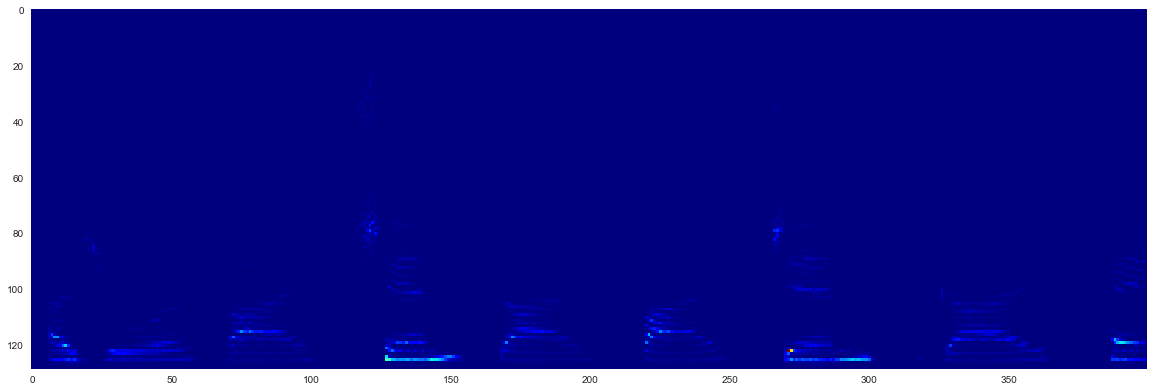

In [103]:
soundfiles = glob.glob('./American-English/*/*.wav')
sound_combined = np.zeros(0)
for file in soundfiles:
    fs, sound = scipy.io.wavfile.read(file)
    sound_combined = np.concatenate((sound_combined, sound))

f,t,spectrogram = scipy.signal.spectrogram(sound_combined, fs)
plt.figure(figsize=(20,20))
plt.imshow(np.flipud(spectrogram)[:,:400], cmap='jet');
plt.grid(False)

In [105]:
# Segment into overlapping segments
segment_len = 20 #samples
segment_step = 5 #samples
segments_lst = []
for t_start in np.arange(0, len(t) - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()
# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X.T)
X_red = pca.transform(X.T)

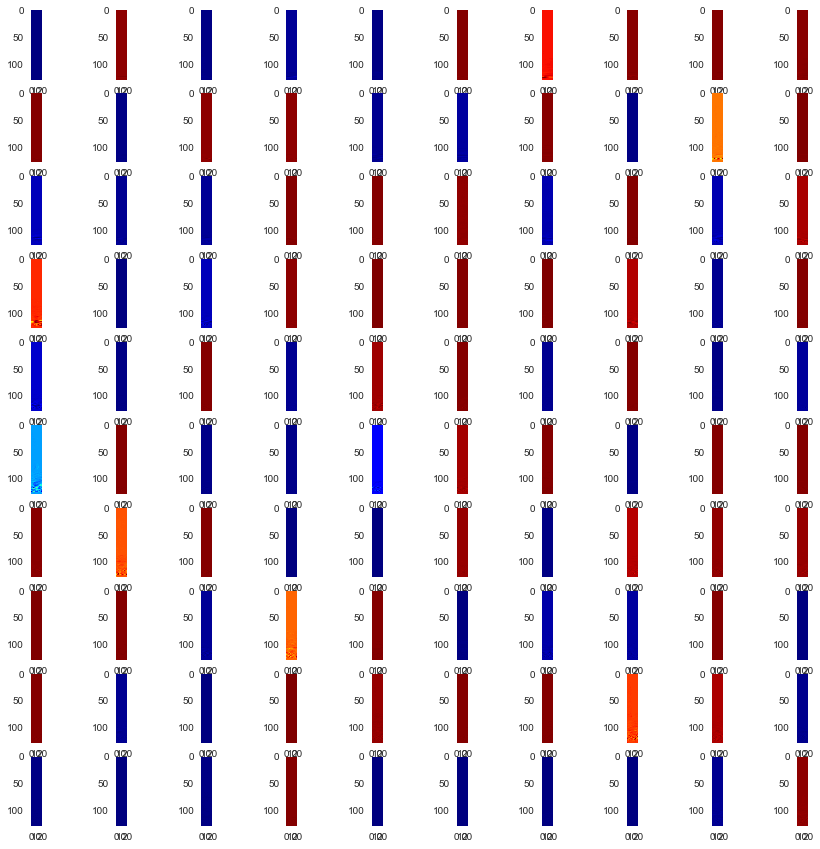

In [206]:
# Visualize principal components
fig, ax = plt.subplots(10, 10, figsize=(15,15))
comp = pca.components_
for i in range(10):
    for j in range(10):
        component = comp[10*i + j,:].reshape((129, 20))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet')

## Start the learning

In [149]:
np.max(A)

0.99998161283031894

In [156]:
s2 = s.ravel()
s2[0] = 1
A2 = do_multiple_learn_steps(y, A, s2, 0.0001, 0.0001, nsteps=100, verbose=True)


[-1.48105266 -1.2183031  -1.84125367 -1.36700518 -1.13475006 -1.19213243
 -1.12078945 -0.91571407 -1.08763799 -1.81993492 -1.08525253 -1.00329101
 -1.93662537 -1.54682528 -1.26197581 -1.33927921 -1.10993307 -1.30132126
 -1.95316994 -0.94013921 -1.62846857 -0.81729356 -1.68537966 -1.42764248
 -1.28881371 -1.82507767 -1.74751893 -1.44501565 -1.71330466 -1.59286274
 -0.89778983 -1.27724102 -1.37399263 -1.71110697 -1.89345801 -0.99516082
 -1.79063756 -1.6409017  -1.32883194 -1.06312282 -1.05863591 -1.67507482
 -1.46321031 -1.80338904 -1.82379743 -1.30649239 -1.8560601  -1.81831104
 -1.62822863 -1.84831857 -1.858052   -1.83881265 -1.48204641 -1.51223341
 -1.0878749  -1.46920304 -1.08384178 -0.95905035 -1.04968725 -1.71721466
 -1.59287125 -1.76397611 -0.89095482 -1.82856676 -1.29413309 -1.02399463
 -1.29697862 -1.68409189 -1.80178853 -1.57714783 -1.65369035 -1.01306116
 -0.9733931  -1.33741422 -1.48263385 -1.9512393  -1.10388158 -1.47641912
 -1.53492308 -1.68861978 -1.84116872 -1.27506671 -1

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract



[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan 

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

In [161]:
Y = comp


(200, 2580)

In [143]:
# Start learning
comp.shape
iters = 10
nfeats = 800
lamb = 1
A = np.random.rand(comp.shape[0], nfeats)
s_lst = []
A_lst = []
tau = 10
eta = 0.1
theta = 0.1

print('Doing iteration #', i)
# Pick a random training example
#idx = np.random.randint(comp.shape[1])
y = comp[:,20]
#y /= np.linalg.norm(y) / 1000

# Find s
s,_ = find_s(tau, A, y, lamb, niter=100, update='paper', verbose=True)
s_lst.append(s)

# Optimize A
A2 = do_multiple_learn_steps(y, A, s.ravel(), eta, theta, nsteps=100)
#A_lst.append(A)

Doing iteration # 9
Cost =  5.77020009548e+12 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . tau = 10
Cost =  500000.0 . 

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract


Best cost =  1000000.0 . Best A =  [[-1902.47866204 -1780.39358799 -1920.08959508 ..., -1805.47436342
  -1820.32925013 -2003.11597263]
 [-1990.89514421 -1869.21712461 -2016.21484199 ..., -1893.3845706
  -1904.0250504  -2099.07989194]
 [-2030.81661885 -1899.74990399 -2050.20151273 ..., -1925.12008633
  -1937.95503933 -2136.56876142]
 ..., 
 [-2066.55773193 -1935.76048344 -2081.1188917  ..., -1962.16794624
  -1976.40588176 -2171.21833998]
 [-2076.94039023 -1944.88613951 -2100.85112612 ..., -1974.20630145
  -1993.63381387 -2183.94070556]
 [-2043.88734176 -1915.81978536 -2068.27953724 ..., -1943.11407571
  -1954.74267247 -2154.63026169]]


In [135]:
# Start learning
comp.shape
iters = 10
nfeats = 800
lamb = 0.000
A = np.random.rand(comp.shape[0], nfeats)
s_lst = []
A_lst = []
tau = 10

for i in range(10):
    print('Doing iteration #', i)
    # Pick a random training example
    #idx = np.random.randint(comp.shape[1])
    y = comp[:,i]
    
    # Find s
    s,_ = find_s(tau, A, y, lamb, niter=100, update='paper')
    s_lst.append(s)
    
    # Optimize A
    A = find_optimal_A(y, s)
    A_lst.append(A)
    

Doing iteration # 0
Best cost =  0.5 Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: invalid value encountered in multiply
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:2652: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in sign


Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

In [38]:
x = A_lst[0].ravel()
y = x[x != 0]
y

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [234]:
Y

array([[ 30.,  20.],
       [ 49.,  10.],
       [ 79.,  60.]])

In [ ]:

s,_ = find_s(100000, A, y/100, lamb=100, niter=1000, update='direct')

#find_s(100000,A_lst[0], y, lamb, niter=100)

In [134]:
A = np.random.rand(comp.shape[0], nfeats)
y = comp[:,0]
#v, e = find_s(tau, A, y, lamb, niter=1000, update='paper')
s = np.array([3,3,4,5], dtype='float')
#y = np.array([30, 49, 79], dtype='float')
tau = 0.1
lamb = 0

y /= np.linalg.norm(y)

v, e = find_s(tau, A, y, lamb, niter=1000, update='paper')

Best cost =  0.499060593917 Best s = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          

## Compute the receptive fields from the columns of A

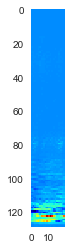

In [66]:
A_inverted = pca.inverse_transform(A.T)
seg = A_inverted[3,:].reshape((129, 20))
plt.imshow(np.flipud(seg), cmap='jet')
plt.grid(False)